# Multilabel Classification

# Setting Up

In [ ]:
!nvidia-smi

Thu Feb 16 16:59:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    24W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [ ]:
! pip install -q transformers[sentencepiece] fastbook fastai ohmeow-blurr nbdev

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 22.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 719.8/719.8 KB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.1/81.1 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 64.8/64.8 KB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 14.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 62.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 15.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 462.8/462.8 KB 19.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 KB 1.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 KB 6.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.0/79.0 KB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
from transformers import AutoModelForSequenceClassification, AutoConfig
from fastai.text.all import *
from blurr.text.data.all import *
from blurr.text.modeling.all import *

/usr/local/lib/python3.8/dist-packages/blurr/text/modeling/question_answering.py:31: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  squad_metric = load_metric("squad")


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/MasterCourse/CapstonProject03

/content/drive/MyDrive/MasterCourse/CapstonProject03


# Data

In [ ]:
df = pd.read_csv("Data/Movies_data.csv")
df.head()

,title,description,genres
0,The Shawshank Redemption,"Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion.",['Drama']
1,The Godfather,The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.,"['Crime', 'Drama']"
2,Daman,"The film is set in 2015. Sid, is a young doctor who completed his MBBS has been posted to the cut-off area of Malkangiri district Odisha having 151 villages & infamous for Naxals dominance & no basic facilities. It's a real life tale of perseverance & dedication.","['Adventure', 'Drama']"
3,Hababam Sinifi,"Lazy, uneducated students share a very close bond. They live together in the dormitory, where they plan their latest pranks. When a new headmaster arrives, the students naturally try to overthrow him. A comic war of nitwits follows.","['Comedy', 'Drama']"
4,The Dark Knight,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.","['Action', 'Crime', 'Drama']"


In [ ]:
df.shape

(9310, 3)

In [ ]:
df = df.dropna().reset_index(drop=True)
df.shape

(9310, 3)

In [ ]:
genres_list = df.genres.to_list()
genre_count = {}
for genres in genres_list:
  genre_list = eval(genres)
  for genre in genre_list:
    if genre in genre_count.keys():
      genre_count[genre] += 1
    else:
      genre_count[genre] = 1
print(f"Number of Genres: {len(genre_count)}")
print(genre_count)

Number of Genres: 21
{'Drama': 5484, 'Crime': 1958, 'Adventure': 1562, 'Comedy': 3382, 'Action': 2290, 'Biography': 660, 'History': 319, 'Mystery': 955, 'Thriller': 1539, 'Animation': 458, 'Fantasy': 667, 'Family': 416, 'Sci-Fi': 641, 'Romance': 1651, 'Western': 116, 'Horror': 1078, 'Music': 267, 'War': 220, 'Sport': 192, 'Film-Noir': 58, 'Musical': 129}


In [ ]:
threshold = int(len(df) * 0.01)
rare_genres = [key for key, value in genre_count.items() if value < threshold]
len(rare_genres), rare_genres[:5]

(1, ['Film-Noir'])

In [ ]:
encode_genre_types = { key: idx for idx, (key, value) in enumerate(genre_count.items())}
with open("genre_types_encoded.json", "w") as fp:
  json.dump(encode_genre_types, fp)

In [ ]:
from ast import literal_eval


'Drama'

In [ ]:
# We need this because for multilabel classification all genres have possibility to be present in the predictions
categorical_genre_list = []
genres_list = df.genres.to_list()

for all_genres in genres_list:
  categorical_list = [0] * len(encode_genre_types)
  genres = literal_eval(all_genres)
  for genre in genres:
    genre_type_index = encode_genre_types[genre] 
    categorical_list[genre_type_index] = 1
  categorical_genre_list.append(categorical_list)

categorical_genre_list[3][:23]

[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [ ]:
df['genre_cat_list'] = categorical_genre_list
df.head()

,title,description,genres,genre_cat_list
0,The Shawshank Redemption,"Over the course of several years, two convicts form a friendship, seeking consolation and, eventually, redemption through basic compassion.",['Drama'],"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
1,The Godfather,The aging patriarch of an organized crime dynasty in postwar New York City transfers control of his clandestine empire to his reluctant youngest son.,"['Crime', 'Drama']","[1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
2,Daman,"The film is set in 2015. Sid, is a young doctor who completed his MBBS has been posted to the cut-off area of Malkangiri district Odisha having 151 villages & infamous for Naxals dominance & no basic facilities. It's a real life tale of perseverance & dedication.","['Adventure', 'Drama']","[1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
3,Hababam Sinifi,"Lazy, uneducated students share a very close bond. They live together in the dormitory, where they plan their latest pranks. When a new headmaster arrives, the students naturally try to overthrow him. A comic war of nitwits follows.","['Comedy', 'Drama']","[1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"
4,The Dark Knight,"When the menace known as the Joker wreaks havoc and chaos on the people of Gotham, Batman must accept one of the greatest psychological and physical tests of his ability to fight injustice.","['Action', 'Crime', 'Drama']","[1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


In [ ]:
df.to_csv("Data/Movies_categorical_data.csv", index=False)  

# Dataloaders and Modeling

In [ ]:
labels = list(encode_genre_types.keys())

In [ ]:
model_name = "distilroberta-base"
model_cls = AutoModelForSequenceClassification
config = AutoConfig.from_pretrained(model_name)
config.num_labels = len(labels)

hf_arch, hf_config, hf_tokenizer, hf_model = get_hf_objects(model_name, model_cls=model_cls, config=config)
hf_model.config.problem_type = "multi_label_classification"

In [ ]:
blocks = (TextBlock(hf_arch, hf_config, hf_tokenizer, hf_model), MultiCategoryBlock(encoded=True,vocab=labels))
dblock = DataBlock(blocks=blocks, get_x=ColReader('description'), get_y=ColReader('genre_cat_list'), splitter=RandomSplitter(valid_pct=0.1, seed=42))

In [ ]:
dls = dblock.dataloaders(df, bs=32)
torch.save(dls, "dataloaders/dls-multilabel-movie-classifier.pkl")

In [ ]:
dls.vocab

['Drama', 'Crime', 'Adventure', 'Comedy', 'Action', 'Biography', 'History', 'Mystery', 'Thriller', 'Animation', 'Fantasy', 'Family', 'Sci-Fi', 'Romance', 'Western', 'Horror', 'Music', 'War', 'Sport', 'Film-Noir', 'Musical']

In [ ]:
dls.show_batch(dataloaders=dls, max_n=4, trunc_at=512)

,text,target
0,"A drama exploring the romantic past and emotional present of Ann Lord (Vanessa Redgrave) and her daughters, Constance Haverford (Natasha Richardson) and Nina Mars (Toni Collette). As Ann lays dying, she remembers, and is moved to convey to her daughters, the defining moments in her life fifty years ago, when she was a young woman. Harris Arden (Patrick Wilson) is the man Ann loves in the 1950s... See full summary »","[Drama, Romance]"
1,"Lynn, a genius high school student who makes money by cheating tests, receives a new task that leads her to set foot on Sydney, Australia. In order to complete the millions-Baht task, Lynn and her classmates have to finish the international STIC(SAT) exam and deliver the answers back to her friends in Thailand before the exam takes place once again in her home country.","[Drama, Crime, Comedy]"
2,What could be better for the village than a scenic railway to bring in the tourists? What could be worse for tourism than war? Luka builds the railway and shuts his eyes to war. Then Luka's wife runs off with a musician and his son is called up to the army. Luka's life is a war zone. Then he meets Sabaha..,"[Comedy, Romance, Music]"
3,"Alexander's day begins with gum stuck in his hair, followed by more calamities. However, he finds little sympathy from his family and begins to wonder if bad things only happen to him, his mom, dad, brother and sister - who all find themselves living through their own terrible, horrible, no good, very bad day.","[Drama, Comedy, Family]"


In [ ]:
doc(accuracy_multi)

In [ ]:
model = BaseModelWrapper(hf_model)
 
acc_02 = partial(accuracy_multi, thresh=0.2)

learner = Learner(dls, 
                  model,
                  opt_func=partial(OptimWrapper, opt=torch.optim.AdamW),
                  loss_func=BCEWithLogitsLossFlat(),
                  metrics=[acc_02],
                  cbs=[BaseModelCallback],
                  splitter=blurr_splitter
                  ).to_fp16()

# Stage - 0

In [ ]:
learner.freeze()

SuggestedLRs(slide=0.0012022644514217973, valley=0.00019054606673307717)

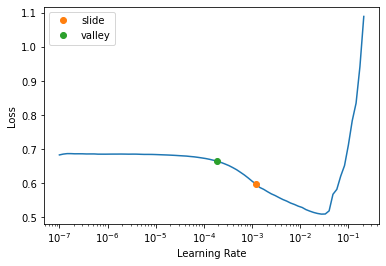

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(2,4.75e-4)

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.224129,0.213107,0.874636,00:16
1,0.204403,0.207377,0.880415,00:16


In [ ]:
learner.save("movie-classifier-stage-0")

Path('models/book-classifier-stage-0.pth')

In [ ]:
learner.export("models/movie-classifier-stage-0.pkl")

# Stage - 1

In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0030199517495930195, valley=2.75422871709452e-06)

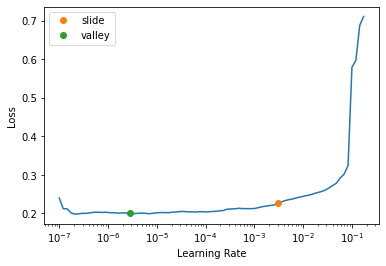

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(3,slice(4.75e-3, 2.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.235566,0.235732,0.861235,00:25
1,0.194421,0.235465,0.876579,00:27
2,0.123571,0.230899,0.881387,00:28


In [ ]:
learner.save("movie-classifier-stage-1")

Path('models/book-classifier-stage-1.pth')

In [ ]:
learner.export("models/movie-classifier-stage-1.pkl")

# Stage - 2


In [ ]:
learner.unfreeze()

SuggestedLRs(slide=0.0012022644514217973, valley=2.511886486900039e-05)

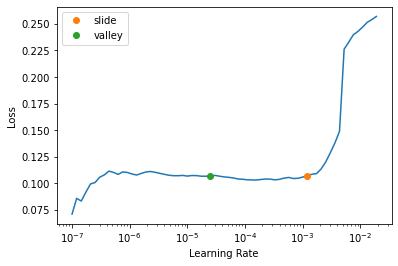

In [ ]:
learner.lr_find(suggest_funcs=[slide, valley])

In [ ]:
learner.fit_one_cycle(7,slice(4.75e-3, 2.25e-5))

epoch,train_loss,valid_loss,accuracy_multi,time
0,0.123631,0.260585,0.884814,00:34
1,0.163943,0.278156,0.864815,00:33
2,0.136117,0.280501,0.876170,00:26
3,0.085909,0.292466,0.879648,00:27
4,0.053745,0.307161,0.883893,00:27
5,0.035442,0.313301,0.884507,00:27
6,0.029471,0.314401,0.885377,00:26


In [ ]:
learner.save("movie-classifier-stage-2")

Path('models/book-classifier-stage-2.pth')

In [ ]:
learner.export("models/movie-classifier-stage-2.pkl")